# ROB 498: Robot Learning for Planning and Control
# Assignment 2: Introduction to Optimal Control 

## Colab Setup

In [29]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ROB498 folder and put all the files under HW2 folder, then 'ROB498/HW2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'C:/Users/kush2/OneDrive/Documents/UMich/Sem2/Robot Learning/project'

### Setup Code 

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import os
import sys

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

files = os.listdir(GOOGLE_DRIVE_PATH)
expected_files = [ 'ROB498_hw2.ipynb', 'base_env.py', 'cartpole_env.py', 'panda_env.py', 'linear_mpc.py', 'mppi_control.py'] 

sys.path.append(GOOGLE_DRIVE_PATH)

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')

Required file ROB498_hw2.ipynb not found!


In [4]:
# Install missing required packages 
# Unfortunately Colab does not have pybullet package by default, so we will have to install it every time that the notebook kernel is restarted.
# Install pybullet -- For simulation purposes
!pip install pybullet
# Install numpngw -- For visualization purposes
!pip install numpngw
!pip install control


In [32]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm

## Assignment Introduction

Due 2/19 at 11:59pm

**Rules**:

1. All homework must be done individually, but you are encouraged to post questions on Piazza

2. No late homework will be accepted (unless you use your late-day tokens)

3. Submit your code on [autograder.io](http://autograder.io/)

4. Remember that copying-and-pasting code from other sources is not allowed

5. The use of additional package imports beyound the packages we provide is not allowed. The autograder will not grade your code if you use additional packages.

**Instructions**
- Each problem will give you a file with some template code, and you need to fill in the
rest.
- We use the autograder, so if you’re ever wondering “will I get full points for
this?” just upload your code in the autograder to check. There is no limit to how
many times you can upload to autograder.
- The autograder may test your problem with multiple different inputs to make sure it is correct.
- The autograder will only show you if you got it right/wrong, so if you don’t get full points, try to test with some other inputs.

## 1 - Cartpole Control (60 points)

In this section you will apply optimal control policies to control one of the classical control problems: the cartpole.


In [33]:
from cartpole_env import *
import pybullet as p
p.connect(p.DIRECT)
p.setPhysicsEngineParameter(enableFileCaching=0)

### Cartpole Setup
The cartpole is an example of an underactuated dynamical system. The goal is to mantain the pole location vertically while only being able to control the cart displacement via applying a linear force $F$.

Below you will see an example of the cartpole system we will be working with. This cartpole is simulated using PyBullet. Here, we will just apply random forces to the cart.


If you want to know more details about the pybullet simulation. You can check the `Cartpole` class in `cartpole_env.py`.

Run the cell below and observe that random actions result in behaviour far from stable.

  0%|          | 0/100 [00:00<?, ?it/s]

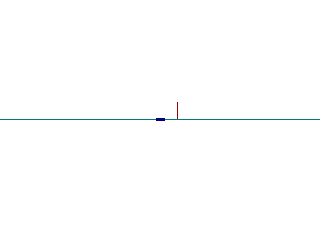

In [34]:
env = CartpoleEnv()
env.reset(state = np.array([0.0, np.pi/2, 0.0, 0.0, 0.0, 0.0]))

frames=[] #frames to create animated png
frames.append(env.render())
for i in tqdm(range(100)):
    action = env.action_space.sample()
    s = env.step(action)
    img = env.render()
    frames.append(img)

write_apng("doublecartpole_example.gif", frames, delay=5)
Image(filename="doublecartpole_example.gif")

In [35]:
env = CartpoleEnv()
env.reset()
params = dump_body_dynamics(env.cartpole)


  0%|          | 0/100 [00:00<?, ?it/s]

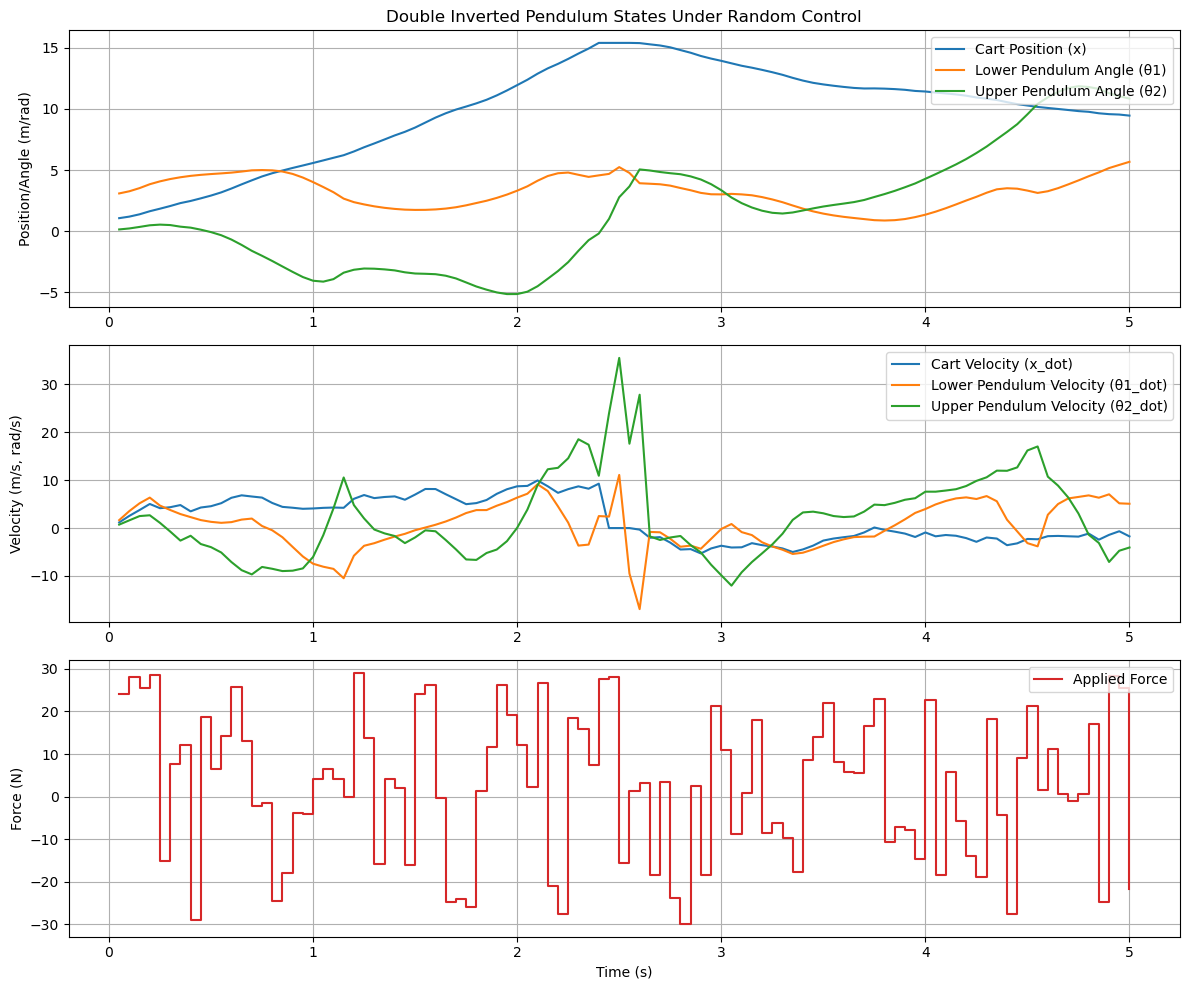

In [36]:


# Initialize environment
env = CartpoleEnv()
initial_state = np.array([1.0, 3, 0.1, 0.0, 0.0, 0.0])  # [x, θ1, θ2, x_dot, θ1_dot, θ2_dot]
env.reset(state=initial_state)

# Storage for states and time
states = []
actions = []
time_points = []
states.append(initial_state)
dt = env.dt

# Simulation loop
for i in tqdm(range(100)):
    action = env.action_space.sample()  # Random action
    next_state = env.step(action)
    
    # Store results
    states.append(next_state)
    actions.append(action)
    time_points.append((i + 1) * dt)  # Time at the end of the step

# Convert to numpy arrays
states = np.array(states)  # Shape: (101, 6)
actions = np.array(actions)  # Shape: (100,)
time_points = np.array(time_points)  # Shape: (100,)

# Create figure with subplots
plt.figure(figsize=(12, 10))

# Plot positions
plt.subplot(3, 1, 1)
plt.plot(time_points, states[1:, 0], label='Cart Position (x)', color='tab:blue')
plt.plot(time_points, states[1:, 1], label='Lower Pendulum Angle (θ1)', color='tab:orange')
plt.plot(time_points, states[1:, 2], label='Upper Pendulum Angle (θ2)', color='tab:green')
plt.ylabel('Position/Angle (m/rad)')
plt.title('Double Inverted Pendulum States Under Random Control')
plt.legend(loc='upper right')
plt.grid(True)

# Plot velocities
plt.subplot(3, 1, 2)
plt.plot(time_points, states[1:, 3], label='Cart Velocity (x_dot)', color='tab:blue')
plt.plot(time_points, states[1:, 4], label='Lower Pendulum Velocity (θ1_dot)', color='tab:orange')
plt.plot(time_points, states[1:, 5], label='Upper Pendulum Velocity (θ2_dot)', color='tab:green')
plt.ylabel('Velocity (m/s, rad/s)')
plt.legend(loc='upper right')
plt.grid(True)

# Plot actions
plt.subplot(3, 1, 3)
plt.step(time_points, actions, label='Applied Force', where='post', color='tab:red')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

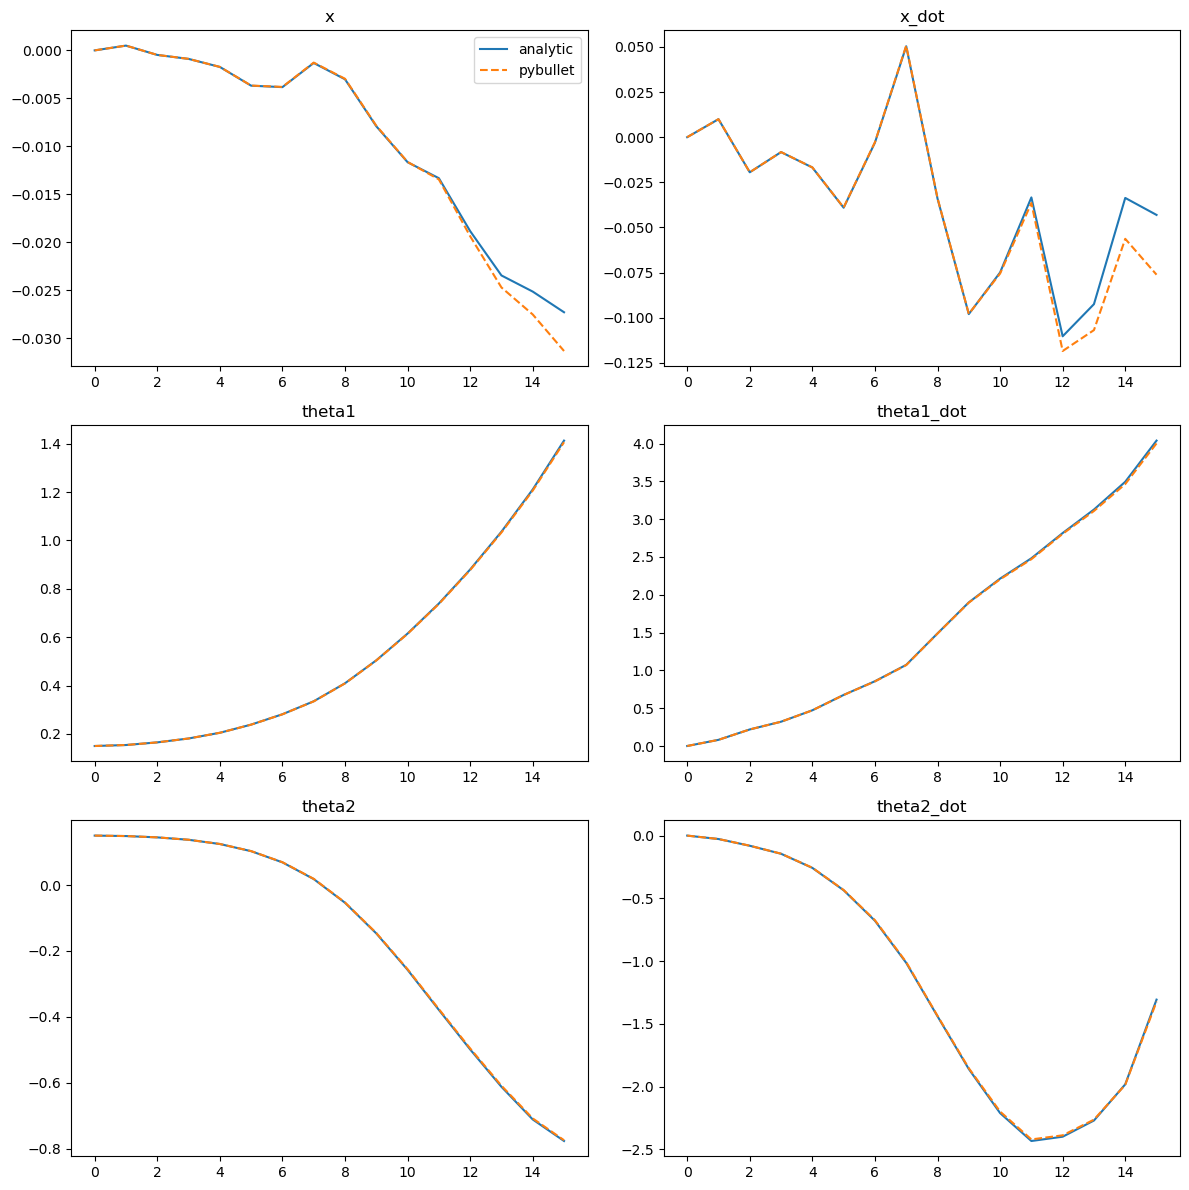

In [38]:
## Let's test to see if your analytic dynamics matches the simulator
import numpy as np
# first let's generate a random control sequence
T = 15
control_sequence = np.random.randn(T, 1)
start_state = np.array([0.0, 0.15, 0.15, 0.0, 0.0, 0.0])  # Initial state for double pendulum

# We use the simulator to simulate a trajectory
env = CartpoleEnv()
env.reset(start_state)
states_pybullet = np.zeros((T+1, 6))  # Now 6 states for double pendulum
states_pybullet[0] = start_state
for t in range(T):
    states_pybullet[t+1] = env.step(control_sequence[t])

# Now we will use your analytic dynamics to simulate a trajectory
states_analytic = torch.zeros(T+1, 1, 6)  # Need an extra 1 which is the batch dimension (T x B x 6)
states_analytic[0] = torch.from_numpy(start_state).reshape(1, 6).float()
for t in range(T):
    current_state = states_analytic[t]
    current_control = torch.from_numpy(control_sequence[t]).reshape(1, 1) # add batch dimension to control    
    states_analytic[t+1] = dynamics_analytic(current_state, current_control)
    
# convert back to numpy for plotting
states_analytic = states_analytic.reshape(T+1, 6).numpy()

# Plot and compare - They should be indistinguishable 
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows now for the additional states

# First column plots
axes[0][0].plot(states_analytic[:, 0], label='analytic')
axes[0][0].plot(states_pybullet[:, 0], '--', label='pybullet')
axes[0][0].title.set_text('x')

axes[1][0].plot(states_analytic[:, 1])
axes[1][0].plot(states_pybullet[:, 1], '--')
axes[1][0].title.set_text('theta1')

axes[2][0].plot(states_analytic[:, 2])
axes[2][0].plot(states_pybullet[:, 2], '--')
axes[2][0].title.set_text('theta2')

# Second column plots
axes[0][1].plot(states_analytic[:, 3])
axes[0][1].plot(states_pybullet[:, 3], '--')
axes[0][1].title.set_text('x_dot')

axes[1][1].plot(states_analytic[:, 4])
axes[1][1].plot(states_pybullet[:, 4], '--')
axes[1][1].title.set_text('theta1_dot')

axes[2][1].plot(states_analytic[:, 5])
axes[2][1].plot(states_pybullet[:, 5], '--')
axes[2][1].title.set_text('theta2_dot')

axes[0][0].legend()
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import torch

# Set print options for NumPy and PyTorch
np.set_printoptions(precision=3, suppress=True, linewidth=150)
torch.set_printoptions(precision=3, sci_mode=False, linewidth=150)

# Generate a random linearization point
x_rand = 0.8 * np.zeros(6)
u_rand = 0.8 * np.zeros(1)

print('x_rand:', np.round(x_rand, 3))
print('u_rand:', np.round(u_rand, 3))
print()

# === NUMERICAL LINEARIZATION ===
A_numerical, B_numerical = linearize_numerical_fast(x_rand, u_rand)

print('Numerical Linearizations are:')
print('A_numerical =\n', A_numerical)
print('B_numerical =\n', B_numerical)
print()

# === AUTOGRAD LINEARIZATION ===
x_rand_tensor = torch.from_numpy(x_rand).float()
u_rand_tensor = torch.from_numpy(u_rand).float()

A_autograd, B_autograd = linearize_pytorch(x_rand_tensor, u_rand_tensor)

print('Autograd Linearizations are:')
print('A_autograd =\n', np.array2string(A_autograd.numpy(), precision=3, suppress_small=True, floatmode='fixed', threshold=np.inf))
print('B_autograd =\n', np.array2string(B_autograd.numpy(), precision=3, suppress_small=True, floatmode='fixed', threshold=np.inf))


# === Compare matrices numerically ===
A_diff = A_numerical - A_autograd.numpy()
B_diff = B_numerical - B_autograd.numpy()

print('\n=== Difference between Numerical and Autograd Jacobians ===')
print('Max |A_numerical - A_autograd| =', np.max(np.abs(A_diff)))
print('Max |B_numerical - B_autograd| =', np.max(np.abs(B_diff)))

print('\nFull A difference matrix (rounded):\n', np.round(A_diff, 4))
print('Full B difference matrix (rounded):\n', np.round(B_diff, 4))



x_rand: [0. 0. 0. 0. 0. 0.]
u_rand: [0.]

Numerical Linearizations are:
A_numerical =
 [[ 1.    -0.005  0.001  0.05   0.     0.   ]
 [ 0.     1.069 -0.032  0.     0.05   0.   ]
 [ 0.    -0.097  1.084  0.     0.     0.05 ]
 [ 0.    -0.092  0.01   1.     0.     0.   ]
 [ 0.     1.38  -0.644  0.     1.     0.   ]
 [ 0.    -1.931  1.686  0.     0.     1.   ]]
B_numerical =
 [[ 0.002]
 [-0.003]
 [ 0.001]
 [ 0.049]
 [-0.062]
 [ 0.021]]

Autograd Linearizations are:
A_autograd =
 [[ 1.000 -0.005  0.001  0.050  0.000  0.000]
 [ 0.000  1.069 -0.032  0.000  0.050  0.000]
 [ 0.000 -0.097  1.084  0.000  0.000  0.050]
 [ 0.000 -0.092  0.010  1.000  0.000  0.000]
 [ 0.000  1.380 -0.644  0.000  1.000  0.000]
 [ 0.000 -1.931  1.686  0.000  0.000  1.000]]
B_autograd =
 [[ 0.002]
 [-0.003]
 [ 0.001]
 [ 0.049]
 [-0.062]
 [ 0.021]]

=== Difference between Numerical and Autograd Jacobians ===
Max |A_numerical - A_autograd| = 3.337860107421875e-06
Max |B_numerical - B_autograd| = 7.450580596923828e-09

Full

## 1.2 Linear MPC

In this section we will use the linearization you have developed above to synthesise a few different controllers. Our goal is to stabilize the cartpole around the 'pole-up' position.  

#### Note on implementation

For the remainder of this question, note from the docstrings that these functions are expected to take in and return NumPy arrays rather than torch.tensors. The reason for this is because the tools we will use in this question (`control`, `cvxpy` and `pybullet`) work with NumPy and not PyTorch. 

In [39]:
from linear_mpc import *

In [12]:
######################### 1.2(a) Part 1 #########################
from cartpole_env import *
from linear_mpc import LinearMPC
import numpy as np

env = CartpoleEnv()
# Linearize around upright
x_ref = np.zeros(6)
u_ref = np.zeros(1)

A, B = env.linearize_numerical(x_ref, u_ref)

# Q penalizes deviation in [x, theta1, theta2, x_dot, theta1_dot, theta2_dot]
Q = np.diag([10.0, 100.0, 100.0, 1.0, 1.0, 1.0])
R = np.array([[0.1]])  # penalize large force

H = 3  # horizon length
controller = LinearMPC(A, B, Q, R, horizon=H)
S, M = controller.compute_SM()

print('S matrix is:')
print(np.round(S, 3))
print('\nM matrix is:')
print(np.round(M, 3))


S matrix is:
[[ 0.002  0.     0.   ]
 [-0.003  0.     0.   ]
 [ 0.001  0.     0.   ]
 [ 0.049  0.     0.   ]
 [-0.062  0.     0.   ]
 [ 0.021  0.     0.   ]
 [ 0.005  0.002  0.   ]
 [-0.006 -0.003  0.   ]
 [ 0.002  0.001  0.   ]
 [ 0.049  0.049  0.   ]
 [-0.067 -0.062  0.   ]
 [ 0.029  0.021  0.   ]
 [ 0.007  0.005  0.002]
 [-0.01  -0.006 -0.003]
 [ 0.005  0.002  0.001]
 [ 0.05   0.049  0.049]
 [-0.078 -0.067 -0.062]
 [ 0.045  0.029  0.021]]

M matrix is:
[[ 1.    -0.005  0.001  0.05   0.     0.   ]
 [ 0.     1.069 -0.032  0.     0.05   0.   ]
 [ 0.    -0.096  1.084  0.     0.     0.05 ]
 [ 0.    -0.092  0.01   1.     0.     0.   ]
 [ 0.     1.378 -0.643  0.     1.     0.   ]
 [ 0.    -1.928  1.683  0.     0.     1.   ]
 [ 1.    -0.014  0.002  0.1   -0.     0.   ]
 [ 0.     1.215 -0.101  0.     0.103 -0.002]
 [ 0.    -0.304  1.263  0.    -0.005  0.104]
 [ 0.    -0.191  0.024  1.    -0.005  0.001]
 [ 0.     2.913 -1.384  0.     1.069 -0.032]
 [ 0.    -4.151  3.57   0.    -0.096  1.084]


Gains for horizon of 30 are:
[[  -2.657  122.047 -161.706   -4.469   -0.375  -25.604]]


  0%|          | 0/100 [00:00<?, ?it/s]

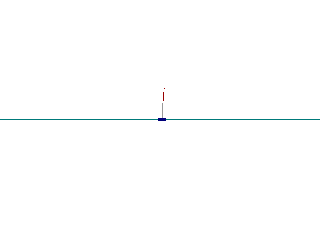

In [13]:
############################## 1.2(a) Part 2 #########################
# Construct controller
controller = LinearMPC(A, B, Q, R, horizon=30)
G = controller.compute_finite_horizon_lqr_gain()

print(f'Gains for horizon of {controller.H} are:')
print(np.round(G, 3))

# === Simulate with LQR controller ===
env.reset(0.1 * np.random.randn(6))  # random initial state

frames = []
for _ in tqdm(range(100)):
    state = env.get_state()
    control = G @ state
    _ = env.step(control)
    img = env.render()
    frames.append(img)

# Save animation
write_apng("double_cartpole_finite_horizon_lqr.gif", frames, delay=10)
Image(filename="double_cartpole_finite_horizon_lqr.gif")


In [14]:
############################## 1.2(b) #########################

# === Compare finite vs infinite horizon ===
for horizon in [5, 10, 50, 800]:
    controller = LinearMPC(A, B, Q, R, horizon=horizon)
    G = controller.compute_finite_horizon_lqr_gain()
    print(f'Gains for finite horizon {controller.H} are:')
    print(np.round(G, 3))
    print('')

# === Infinite horizon gain ===
Ginf = controller.compute_lqr_gain()
print('Gains for infinite horizon are:')
print(np.round(Ginf, 3))


Gains for finite horizon 5 are:
[[ -0.962  53.135 -35.56   -0.576   5.624  -4.161]]

Gains for finite horizon 10 are:
[[   0.97   103.059 -103.242    1.06     6.56   -14.371]]

Gains for finite horizon 50 are:
[[  -4.883  119.861 -180.721   -8.434   -5.122  -29.971]]

Gains for finite horizon 800 are:
[[ -0.     59.065 -39.099  -0.      6.764  -4.477]]

Gains for infinite horizon are:
[[  -5.085  124.516 -188.065   -8.855   -5.401  -31.219]]


  0%|          | 0/100 [00:00<?, ?it/s]

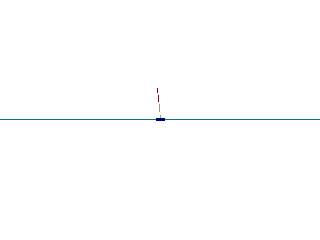

In [16]:
############################## 1.2(c) Part 1 #########################

# === Control bounds ===
u_min = np.array([-5])
u_max = np.array([5])
horizon = 30
# === Build controller ===
controller = LinearMPC(A, B, Q, R, horizon=horizon)

# === Simulate in environment ===
env.reset(0.1 * np.random.randn(6))  # small perturbation from upright
frames = []

for _ in tqdm(range(100)):
    state = env.get_state()
    U = controller.lqr_box_constraints_qp_shooting(state, u_min, u_max)
    u = U[0]  # Apply only the first control
    _ = env.step(u)
    img = env.render()
    frames.append(img)

# === Save animation ===
write_apng("double_cartpole_box_constrained_lqr_shooting.gif", frames, delay=10)
Image(filename="double_cartpole_box_constrained_lqr_shooting.gif")


  0%|          | 0/100 [00:00<?, ?it/s]

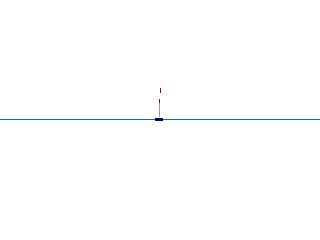

In [18]:
############################## 1.2(c) Part 2 #########################

horizon = 20

u_min = np.array([-5])
u_max = np.array([5])

controller = LinearMPC(A, B, Q, R, horizon=horizon)

# === Simulate with collocation controller ===
env.reset(0.1 * np.random.randn(6))
frames = []

for _ in tqdm(range(100)):
    state = env.get_state()
    U, X = controller.lqr_box_constraints_qp_collocation(state, u_min, u_max)
    u = U[0]
    _ = env.step(u)
    img = env.render()
    frames.append(img)

# === Save gif ===
write_apng("double_cartpole_box_constrained_lqr_collocation.gif", frames, delay=10)
Image(filename="double_cartpole_box_constrained_lqr_collocation.gif")


In [19]:

# === Step 3: Controller with large horizon ===
controller = LinearMPC(A, B, Q, R, horizon=200)
u_min = np.array([-1])
u_max = np.array([1])

# === Step 4: Small perturbation from upright ===
state = np.array([0.01, -0.0005, -0.001, 0.0004, 0.0002, -0.0003])  # 6D state

# === Step 5: Shooting Test ===
print('Testing Shooting MPC with Horizon = 200')
try:
    U_shooting = controller.lqr_box_constraints_qp_shooting(state, u_min, u_max)
    print('✅ Shooting method solved')
except Exception as e:
    print('❌ Shooting method failed to solve')
    print(e)

print('')

# === Step 6: Collocation Test ===
print('Testing Collocation MPC with Horizon = 200')
try:
    U_collocation, X_collocation = controller.lqr_box_constraints_qp_collocation(state, u_min, u_max)
    print('✅ Collocation method solved')
except Exception as e:
    print('❌ Collocation method failed to solve')
    print(e)


Testing Shooting MPC with Horizon = 200
❌ Shooting method failed to solve
Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

Testing Collocation MPC with Horizon = 200
✅ Collocation method solved


# 2 - Advanced Trajectory Optimization - MPPI (40 points)

In this part we will implement Model Predictive Path Integral (MPPI) [Williams et al., ICRA 2017](https://ieeexplore.ieee.org/document/7989202), a trajectory optimization algorithm. This method uses a dynamics model (a simulator, a learned model, or analytical model) to roll out trajectories. This method has been shown to be more efficient and useful for high-dimensional spaces than other model predictive control (MPC) approaches.

You can refer to the original paper for more details about the algorithm.


In this section we are providing you a skeleton of a MPPI controller in `mppi_control.py`. You will have to implement parts of `MPPIController` that perform some of the controller key steps.

**TODO**:
Implement the following functions from `MPPIController`:

1. `_rollout_dynamics`: given an initial state and a set of perturbed actions, compute the resultant states.

  Compute $\mathbf x_0, \dots, \mathbf x_{T}$ for each of the $K$ trajectories, where
$$
\mathbf x^k_t \leftarrow \mathbf F(\mathbf x^k_{t-1}, \mathbf u_{t-1} + \epsilon^k_{t-1})
$$
  where $\epsilon_t^k$ are the perturbation applied to the nominal action sequence $\mathbf u_0, \dots \mathbf u_{T-1}$ (actions without perturbations).
    
    You will have to use batched operations.
2. `_compute_trajectory_cost`: given K different trajectories and control perturbations $\epsilon$, it computes the cost associated to each of the K trajectories. For the state cost, here we will be using a quadratic state cost with *NO terminal cost*, i.e. 
$$
\text{cost}^k = \sum_{t=1}^T (\mathbf x_t^k -\mathbf x_\text{goal})^\top \mathbf Q (\mathbf x_t^k -\mathbf x_\text{goal}) + \lambda \mathbf u_{t-1}^\top \Sigma^{-1} \epsilon^k_{t-1}
$$
    Again, you will have to do batched operations. You should avoid using any for loop in your implementation for this part.
3. `_nominal_trajectory_update`: Last, once we have the trajectory costs computed this part will update the nominal trajectory. In particular it will do the following operations.
    1. $\beta \leftarrow \min_{k}[\text{cost}^k]$
    2. $ \gamma^k \leftarrow  \exp(-\frac{1}{\lambda}(\text{cost}^k - \beta))$
    3. $\eta \leftarrow \sum_{k=1}^{K} \gamma^k$
    4. $\omega^k \leftarrow \frac{1}{\eta}\gamma^k$
    5. $u_t \mathrel{+}= \sum_{k=1}^K \omega^k \epsilon^k_t$
     Again, you will have to do batched operations. You should avoid using any for loop in your implementation for this part.
     
Finally you will have to play with the MPPI hyperparams for each of the two environments that we will test: the cartpole and a panda robot.

In [40]:
from mppi_control import MPPIController, get_cartpole_mppi_hyperparams

  0%|          | 0/100 [00:00<?, ?it/s]

Creating animation...
CPU times: total: 2.64 s
Wall time: 2.7 s
CPU times: total: 0 ns
Wall time: 19 ms


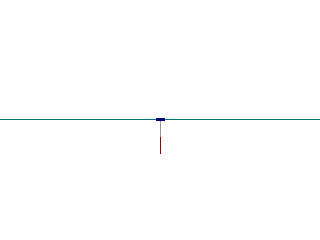

In [28]:

# === Initialize environment and goal ===
env = CartpoleEnv()
env.reset(np.array([0.0, np.pi, np.pi, 0.0, 0.0, 0.0]) + 0.01 * np.random.randn(6))
goal_state = np.zeros(6)

# === MPPI Controller ===+
controller = MPPIController(env, num_samples=500, horizon=20, hyperparams=get_cartpole_mppi_hyperparams())
controller.goal_state = torch.tensor(goal_state, dtype=torch.float32)

# === Simulate and visualize ===
frames = []
num_steps = 100
pbar = tqdm(range(num_steps))

for i in pbar:
    state = env.get_state()
    state = torch.tensor(state, dtype=torch.float32)
    control = controller.command(state)
    next_state = env.step(control)
    
    error = np.linalg.norm(next_state[1:3] - goal_state[1:3])
    pbar.set_description(f"Goal Error: {error:.4f}")
    
    img = env.render()
    frames.append(img)
    
    if error < 1:
        break

print("Creating animation...")
%time write_apng("double_cartpole_mppi.gif", frames, delay=10)
%time Image(filename="double_cartpole_mppi.gif")
